In [ ]:
# Install required libs
!pip install albumentations  
!pip install segmentation-models-pytorch

In [233]:
import os
import numpy as np
import cv2
from PIL import Image
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.transforms import ToPILImage
from skimage.morphology import skeletonize

from torch.optim.lr_scheduler import ReduceLROnPlateau

import segmentation_models_pytorch as smp
from albumentations import *
import time

In [3]:
!cp /content/drive/"My Drive"/segmentation/3d_segmentation/training_data.zip /content/
!cp /content/drive/"My Drive"/segmentation/3d_segmentation/metadata.csv /content/

In [ ]:
!unzip training_data.zip 

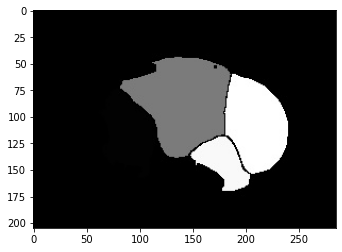

In [5]:
df = pd.read_csv("metadata.csv")
im = cv2.imread(df["mask"].values[100])
plt.imshow(im)

In [79]:


def canny(gray):
    im = cv2.Canny(gray,100,200,apertureSize = 5)
    return im

In [ ]:
def erode(image):
    kernel = np.ones((2, 2), np.uint8) 
    image = cv2.erode(image, kernel) 
    return image

In [296]:
def dilate(image):
    kernel = np.ones((2, 2), np.uint8) 
    image = cv2.dilate(image,kernel,iterations = 3)
    return image


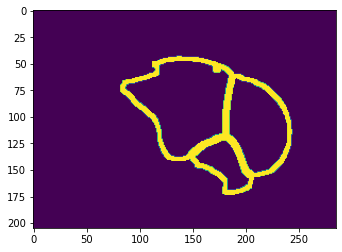

In [297]:
foo = dilate(canny(im))
# foo = cv2.blur(foo,(3,3))
plt.imshow(foo)

In [298]:
def skeleton(image):
    thresh_binary = threshold_image_np(image, 10, invert = False, final_value = 1 )
    skeleton = skeletonize(thresh_binary).astype(np.float32)
    return skeleton

In [380]:
class SegmentationDataset(Dataset):   
    def __init__(self, metadata_csv, augmentation =None, transform = None):
        self.metadata = pd.read_csv(metadata_csv)
        
        
        self.image_paths  = self.metadata["image"]
        self.mask_paths  =  self.metadata["mask"]
        self.transform = transform
        self.augmentation = augmentation


    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], 0)
        mask = cv2.imread(self.mask_paths[idx], 0)

        if self.augmentation is not None:
                
            augmented  = self.augmentation(image = image, mask = mask)
            image = augmented["image"]
            mask = augmented["mask"]
        


       
        # mask = cv2.resize(mask, (256,256))
        mask[mask != 0] = 255

        border = dilate(canny(mask))

        # border = cv2.blur(border, (7,7))

        mask = mask - border

        return self.transform(image), self.transform(mask)
    
    def __len__(self):
        return len(self.image_paths)

In [381]:

        

train_dataset = SegmentationDataset(metadata_csv = "metadata.csv",
                                    augmentation =  Compose([
                                                            # GridDistortion(p=0.5),
                                                            Transpose(p=0.5),
                                                            VerticalFlip(p=0.5),
                                                            HorizontalFlip(p=0.5),
                                                            RandomRotate90(p=0.5),
                                                            # RandomBrightnessContrast( p=0.5),
                                                            ]),

                                    transform = transforms.Compose([ 
                                                                    
                                                                    transforms.ToPILImage(),
                                                                    transforms.Resize((256,256), interpolation = Image.NEAREST),
                                                                    ToTensor(),

                                                                ])
)

In [382]:
train_batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle = True)
print(len(train_loader))


559


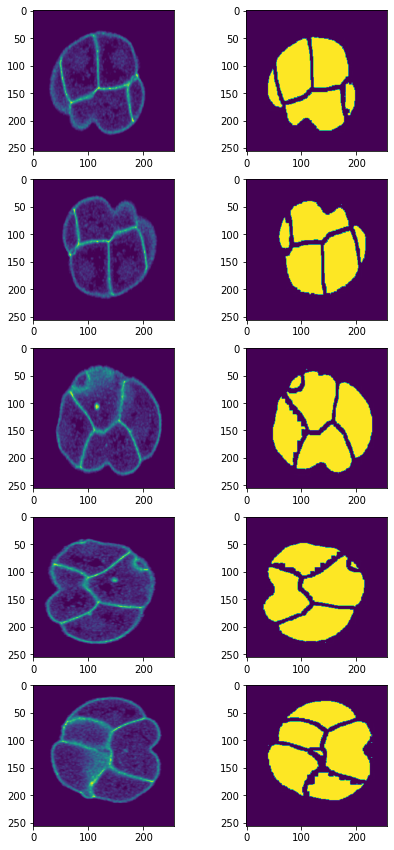

In [383]:
batch  = next(iter(train_loader))

images, masks = batch
fig, ax = plt.subplots(5, 2, figsize = (7,15))

for i in range(5):

    ax[i][0].imshow(images[i][0])
    ax[i][1].imshow(masks[i][0])


In [202]:
# workaround to fix model download 
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context


In [384]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ["nucleus"]
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'
in_channels = 1

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
    in_channels = in_channels 
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [385]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00015),
])


scheduler = ReduceLROnPlateau(optimizer, 
                                mode='min', 
                                factor=0.7, 
                                patience=12, 
                                verbose=False, 
                                threshold=0.0001, 
                                threshold_mode='rel', 
                                cooldown=0, 
                                min_lr=0, 
                                eps=1e-08)

In [386]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)
valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=False,
)


In [387]:
max_score = 0
dice_losses = []
iou_scores  = []
times = []
lrs = []

In [388]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

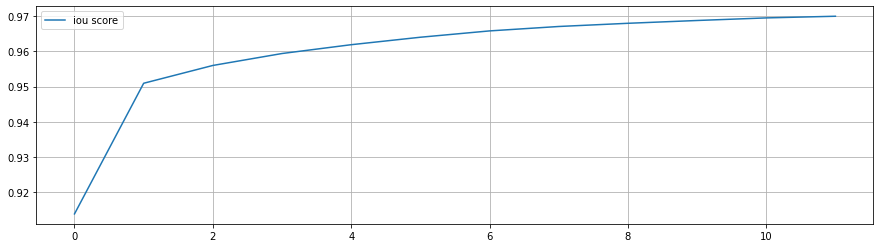

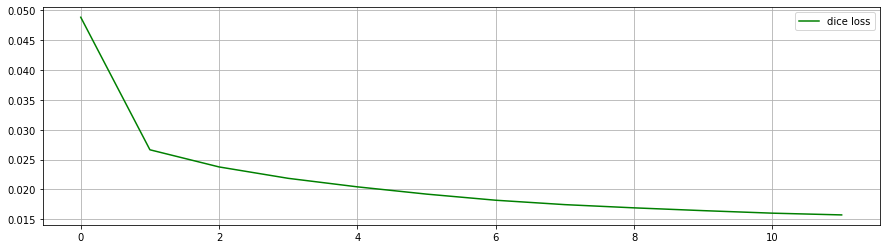

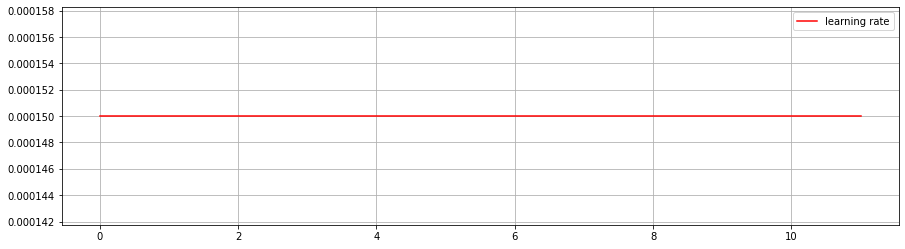


Epoch: 12
train:  75%|███████▌  | 421/559 [02:04<00:40,  3.39it/s, dice_loss - 0.01549, iou_score - 0.9704]


KeyboardInterrupt: ignored

In [389]:
epochs = 20
plt.rcParams['figure.figsize'] = 15, 4
start_time = time.process_time()

for i in range(0, epochs):

    print('\nEpoch: {}'.format(i))

    train_logs = train_epoch.run(train_loader)
    # valid_logs = valid_epoch.run(train_loader)

    dice_losses.append(train_logs["dice_loss"]) 
    times.append(time.process_time() - start_time)
    iou_scores.append(train_logs["iou_score"])

    scheduler.step(1.)
    lrs.append(get_lr(optimizer))

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

    clear_output(wait = True)
    
    plt.plot(iou_scores, label = "iou score")
    plt.legend()
    plt.grid()
    plt.show()

    plt.plot(dice_losses, color = "green", label = "dice loss")
    plt.legend()
    plt.grid()
    plt.show()

    plt.plot(lrs, label = "learning rate", color = "red")
    plt.legend()
    plt.grid()
    plt.show()


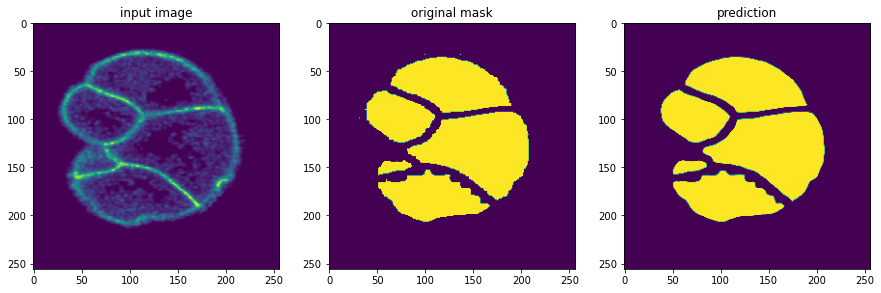

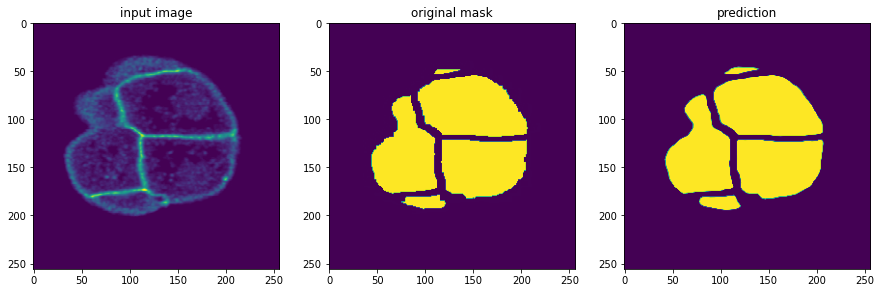

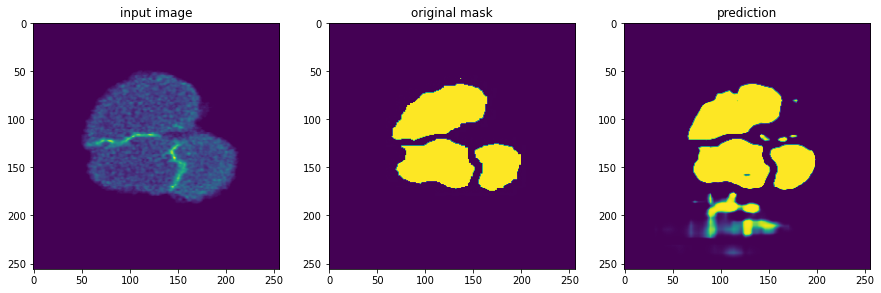

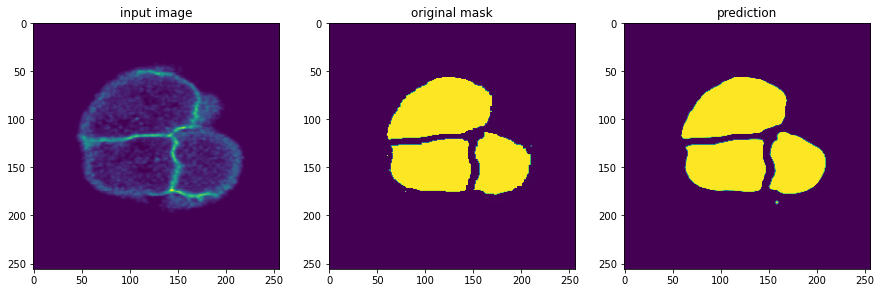

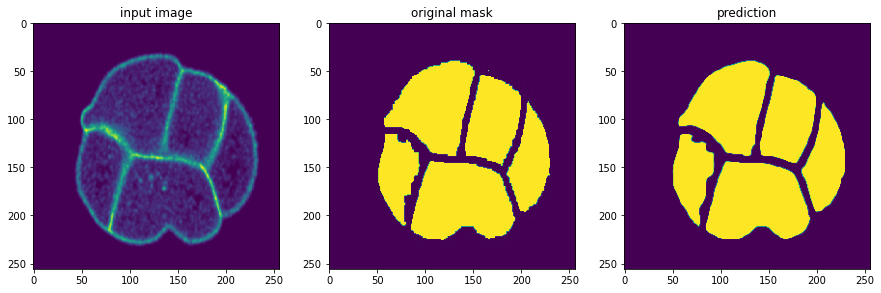

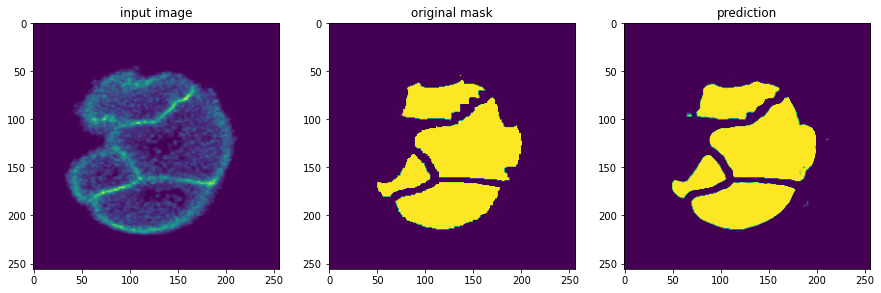

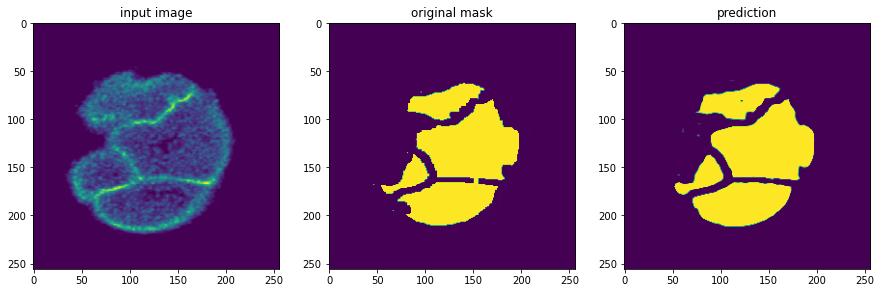

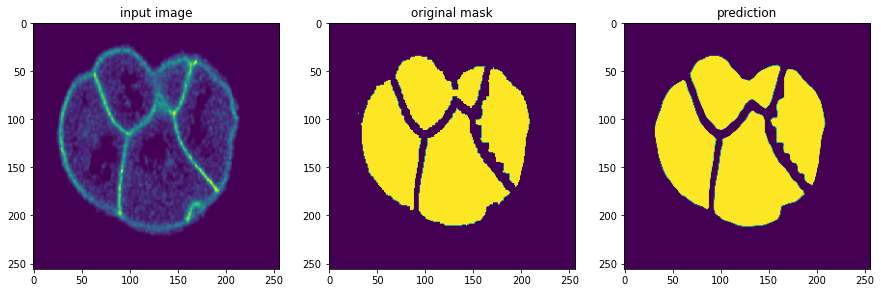

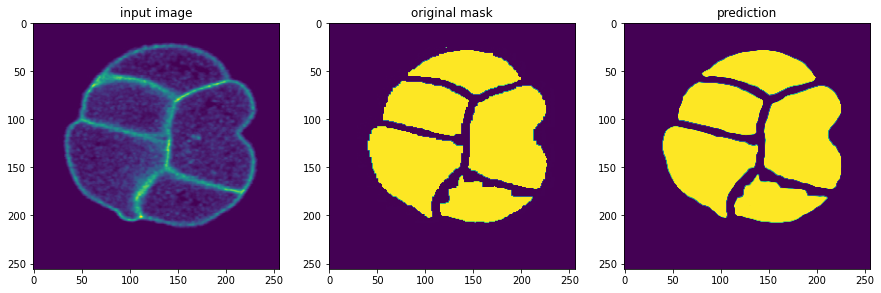

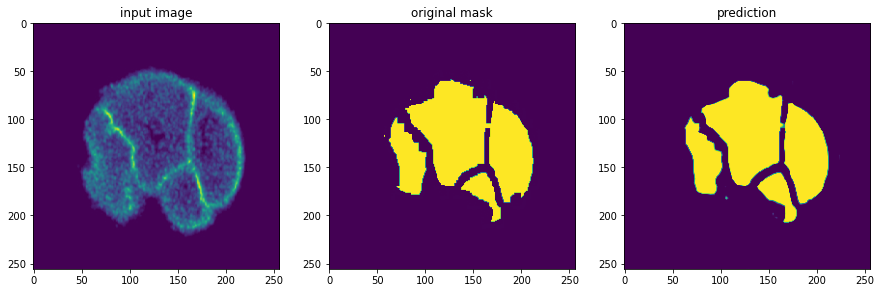

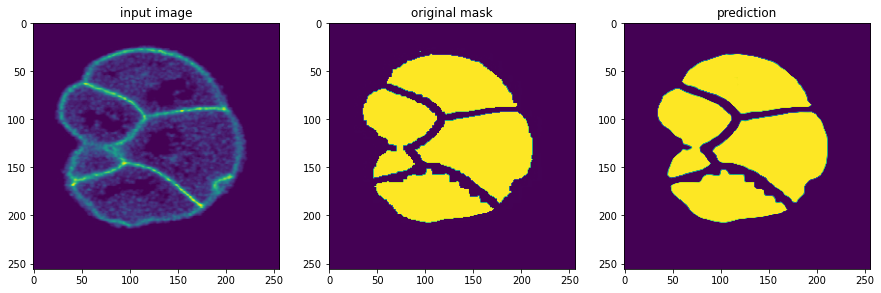

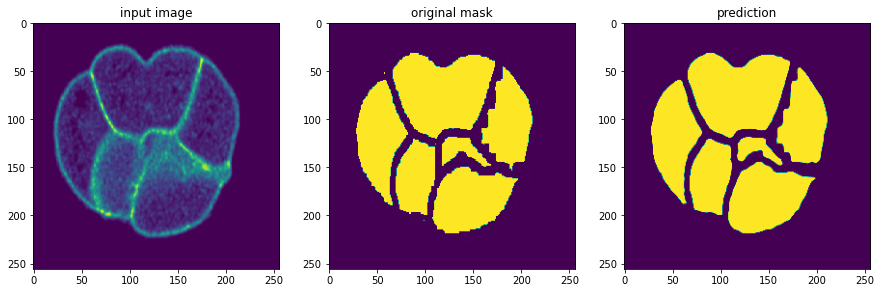

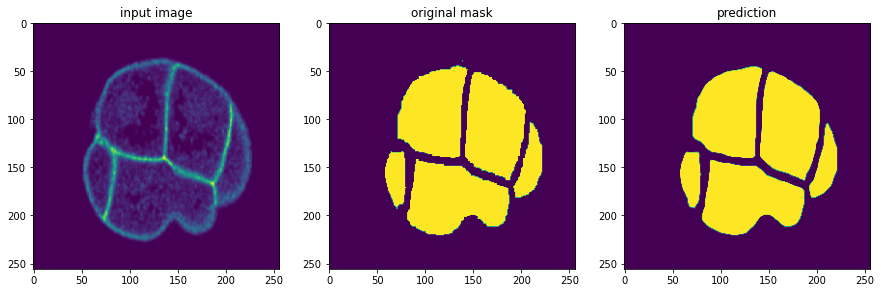

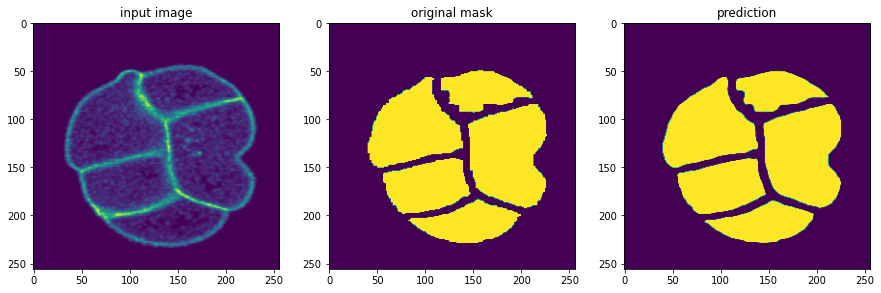

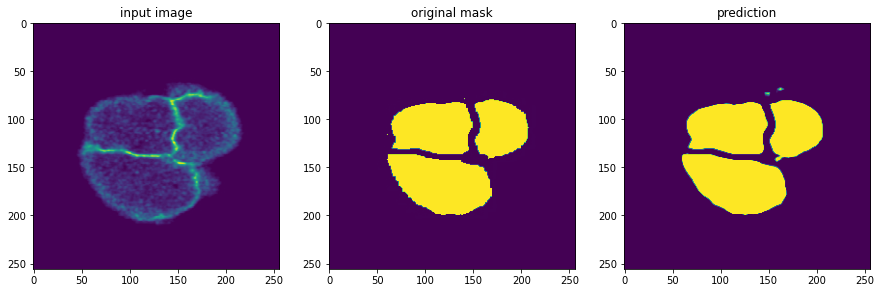

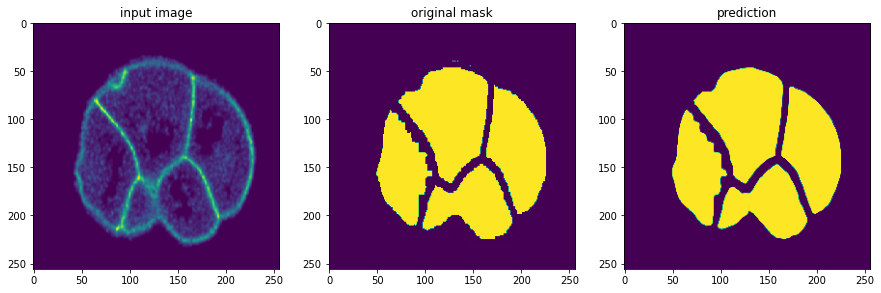

In [390]:
image, masks = next(iter(train_loader))

for i in range(len(image)):
    inp = image[i].cuda().unsqueeze(0)
    pred = model(inp).squeeze(0).squeeze(0).detach().cpu()
    show_img = inp.cpu()[0][0]
    show_pred = model(inp).squeeze(0).squeeze(0).detach().cpu()
    # show_pred[show_pred > 0.1] = 1
    show_mask = masks[i][0].cpu()
    fig, ax = plt.subplots(1,3, figsize = (15,35))

    ax.flat[0].imshow(show_img)
    ax.flat[0].title.set_text('input image')
    
    ax.flat[1].imshow(show_mask)
    ax.flat[1].title.set_text('original mask')

    ax.flat[2].imshow(show_pred)
    ax.flat[2].title.set_text('prediction')

In [439]:
 torch.save(model, '/content/drive/My Drive/segmentation/3d_segmentation/best_model.pth')
torch.save(model, 'best_model.pth')


In [396]:
images = os.listdir("training_data/images")

['real_67_55.jpg',
 'real_66_28.jpg',
 'real_85_30.jpg',
 'real_49_48.jpg',
 'real_65_38.jpg']

In [398]:
exp = []
for i in range(len(images)):
    if images[i][:6] == "real_0":
        exp.append(images[i])




In [403]:
exp = np.sort(np.array(exp))

In [411]:
mini_transform = transforms.Compose([
                                     transforms.ToPILImage(),
                                     transforms.Resize((256,256), interpolation = Image.NEAREST),
                                     transforms.ToTensor(),
])

def path_to_result(path, model):
    model.eval()
    im = cv2.imread(path,0)
    tensor = mini_transform(im).unsqueeze(0).cuda()
    res = model(tensor).detach().cpu().numpy()[0][0]
    return res

In [ ]:
model.eval()

save_folder = "animation"
# os.mkdir(save_folder)
for i in range(len(exp)):
    savename = save_folder + "/" + str(i) + ".jpg"
    fig, ax = plt.subplots(1,2, figsize = (10,10))
    pred = path_to_result("training_data/images/" + exp[i], model)
    image = cv2.imread("training_data/images/" + exp[i],0)
    pred = cv2.resize(pred, image.shape[::-1])
    clear_output(wait= True)

    ax.flat[0].imshow(image)
    ax.flat[1].imshow(pred, cmap = "gray")
    fig.savefig(savename)

In [436]:
names = [ "animation/" + str(i) + ".jpg" for i in range (0, 48, 1)]
images = []
for n in names:
    frame = Image.open(n)
    images.append(frame)
print(len(images))

48


In [438]:
images[0].save('pred.gif',
               save_all=True,
               append_images=images[1:],
               duration=100,
               loop=0)